In [1]:
# Read data
import pandas as pd
import numpy as np

crime_data = pd.read_csv('./Post-covid.csv')

In [2]:
crime_data['Month'] = pd.to_datetime(crime_data['Date']).dt.month
#df.sort_values(by=['Year'])


crime_data.drop('ID', axis=1, inplace=True)
crime_data.drop('Case Number', axis=1, inplace=True)
crime_data.drop('IUCR', axis=1, inplace=True)
crime_data.drop('Beat', axis=1, inplace=True)
crime_data.drop('Updated On', axis=1, inplace=True)
crime_data.drop('Latitude', axis=1, inplace=True)
crime_data.drop('Longitude', axis=1, inplace=True)
crime_data.drop('Location', axis=1, inplace=True)
crime_data.drop('FBI Code', axis=1, inplace=True)
crime_data.drop('Block', axis=1, inplace=True)
crime_data.drop('X Coordinate', axis=1, inplace=True)
crime_data.drop('Y Coordinate', axis=1, inplace=True)
crime_data.drop('Date', axis=1, inplace=True)


crime_data.sort_values(by='Year',ascending=True)

display(crime_data.head())

for col in crime_data.columns:
    crime_data[col] = col + '-' + crime_data[col].astype(str)
    
display(crime_data.head())

,Primary Type,Description,Location Description,Arrest,Domestic,District,Ward,Community Area,Year,Month
0,BURGLARY,FORCIBLE ENTRY,BARBERSHOP,False,False,24.0,50.0,2.0,2020,12
1,THEFT,OVER $500,RESIDENCE - GARAGE,False,False,25.0,26.0,22.0,2020,12
2,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,RESIDENCE,False,True,11.0,28.0,27.0,2020,11
3,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,True,False,8.0,14.0,63.0,2020,11
4,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,APARTMENT,False,False,1.0,3.0,33.0,2020,11


,Primary Type,Description,Location Description,Arrest,Domestic,District,Ward,Community Area,Year,Month
0,Primary Type-BURGLARY,Description-FORCIBLE ENTRY,Location Description-BARBERSHOP,Arrest-False,Domestic-False,District-24.0,Ward-50.0,Community Area-2.0,Year-2020,Month-12
1,Primary Type-THEFT,Description-OVER $500,Location Description-RESIDENCE - GARAGE,Arrest-False,Domestic-False,District-25.0,Ward-26.0,Community Area-22.0,Year-2020,Month-12
2,Primary Type-SEX OFFENSE,Description-SEXUAL EXPLOITATION OF A CHILD,Location Description-RESIDENCE,Arrest-False,Domestic-True,District-11.0,Ward-28.0,Community Area-27.0,Year-2020,Month-11
3,Primary Type-MOTOR VEHICLE THEFT,Description-AUTOMOBILE,Location Description-STREET,Arrest-True,Domestic-False,District-8.0,Ward-14.0,Community Area-63.0,Year-2020,Month-11
4,Primary Type-WEAPONS VIOLATION,Description-RECKLESS FIREARM DISCHARGE,Location Description-APARTMENT,Arrest-False,Domestic-False,District-1.0,Ward-3.0,Community Area-33.0,Year-2020,Month-11


In [3]:
# Converting to tuples as Apriori takes transaction data as input (list of lists)

crime_data_tuples = [tuple(row) for row in crime_data.values.tolist()]
print("Total number of records =", len(crime_data_tuples))

Total number of records = 319531


In [4]:
min_support = 0.05
min_confidence = 0.5
min_lift = 1

In [5]:
# Running Aprior

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from datetime import datetime


te = TransactionEncoder()
te_ary = te.fit(crime_data_tuples).transform(crime_data_tuples)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

start=datetime.now()
frq_items = apriori(df, min_support = min_support, use_colnames = True)
print("Time taken to run Apriori:", datetime.now() - start)

Time taken to run Apriori: 0:00:27.073121


# Efficient apriori

from efficient_apriori import apriori

start=datetime.now()
itemsets, rules = apriori(crime_data_tuples, min_support=min_support, min_confidence=min_confidence)
print("Time taken to run Efficient Apriori:", datetime.now() - start)
print("Number of rules generated:", len(rules))  
display(rules)  

In [6]:
# Formatting, formatting and writing the frequent itemset to csv

rules = association_rules(frq_items, metric ="lift", min_threshold = min_lift)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules['antecedents_length'] = rules['antecedents'].apply(lambda x: len(x))

rules['consequent support'] = rules['consequent support'].round(decimals = 2)
rules['antecedent support'] = rules['antecedent support'].round(decimals = 2)
rules['support'] = rules['support'].round(decimals = 2)
rules['confidence'] = rules['confidence'].round(decimals = 2)
rules['lift'] = rules['lift'].round(decimals = 2)

filtered_rules = rules[(rules['confidence']  >= min_confidence)&((rules['antecedents_length']  == 1)) ]


print("Number of rules generated:", len(filtered_rules))  

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(filtered_rules.head())
    
filtered_rules.to_csv('Post-Apriori.csv', columns = ['antecedents','consequents','support','confidence','lift'], sep=',', encoding='utf-8', index=False)

Number of rules generated: 94


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length
71,(Description-TO PROPERTY),(Primary Type-CRIMINAL DAMAGE),0.06,0.12,0.06,1.0,8.08,0.054227,inf,1
50,(Description-$500 AND UNDER),(Primary Type-THEFT),0.08,0.19,0.08,1.0,5.34,0.064731,inf,1
61,(Description-OVER $500),(Primary Type-THEFT),0.05,0.19,0.05,1.0,5.34,0.044468,inf,1
55,(Description-DOMESTIC BATTERY SIMPLE),(Primary Type-BATTERY),0.10,0.20,0.10,1.0,5.01,0.079008,inf,1
111,(Month-1),(Year-2021),0.05,0.49,0.05,1.0,2.02,0.025307,inf,1


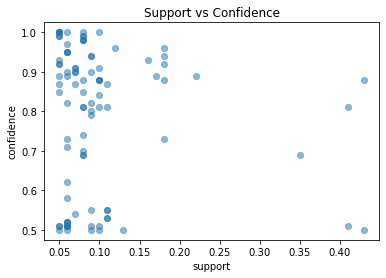

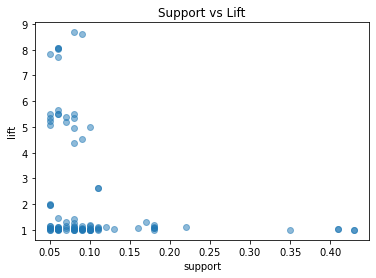

In [7]:
import matplotlib.pyplot as plt
plt.scatter(filtered_rules['support'], filtered_rules['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

plt.scatter(filtered_rules['support'], filtered_rules['lift'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('lift')
plt.title('Support vs Lift')
plt.show()